In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
import pandas as pd 
import numpy as np

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/benvictoria21/pandas/master/dataset/testset.csv")

In [3]:
df.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [4]:
df[' _conds'].value_counts()

Haze                             47602
Smoke                            20760
Mist                              9375
Clear                             3129
Widespread Dust                   2856
Fog                               2760
Scattered Clouds                  2209
Partly Cloudy                     2091
Shallow Fog                       1860
Mostly Cloudy                     1537
Light Rain                        1302
Partial Fog                       1031
Patches of Fog                     901
Thunderstorms and Rain             486
Heavy Fog                          421
Light Drizzle                      414
Rain                               394
Unknown                            383
Blowing Sand                       378
Overcast                           326
Thunderstorm                       192
Light Thunderstorms and Rain       176
Drizzle                            112
Light Fog                           64
Light Thunderstorm                  64
Heavy Rain               

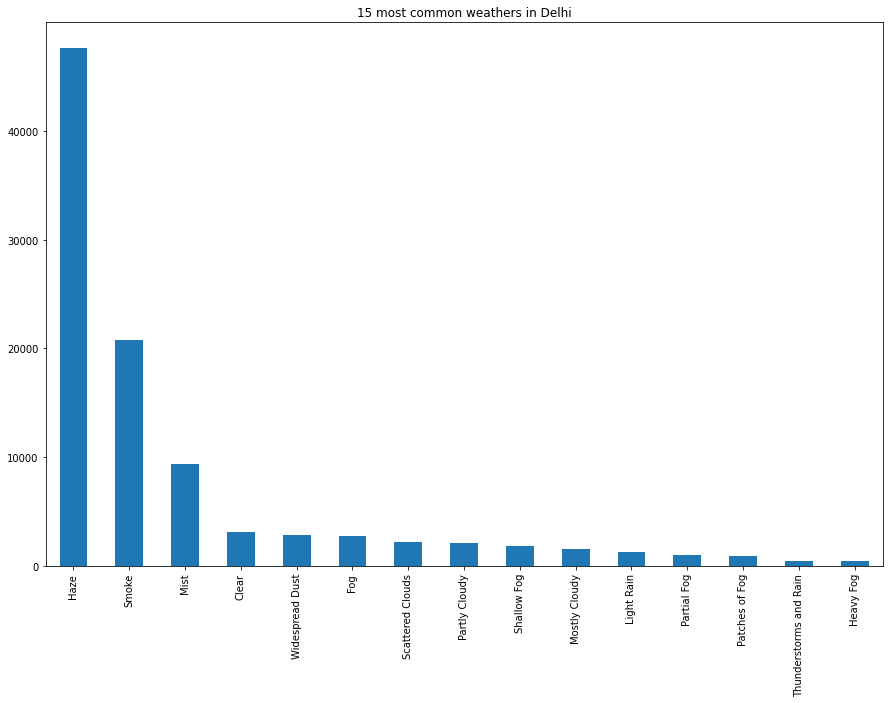

In [5]:
plt.figure(figsize=(15,10))
df[' _conds'].value_counts().head(15).plot(kind='bar')

plt.title('15 most common weathers in Delhi')
plt.show()

[]

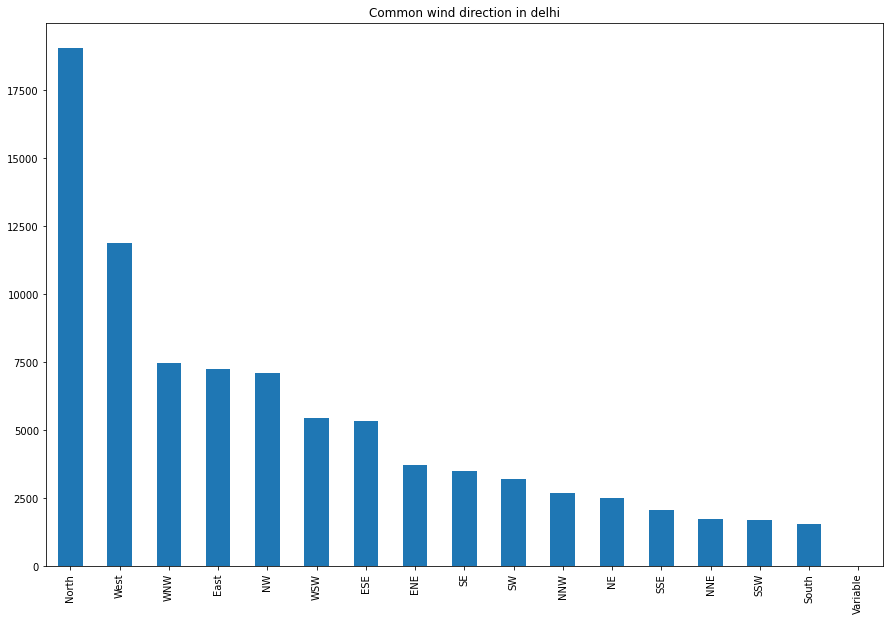

In [6]:
plt.figure(figsize=(15, 10))
plt.title("Common wind direction in delhi")
df[' _wdire'].value_counts().plot(kind="bar")
plt.plot()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


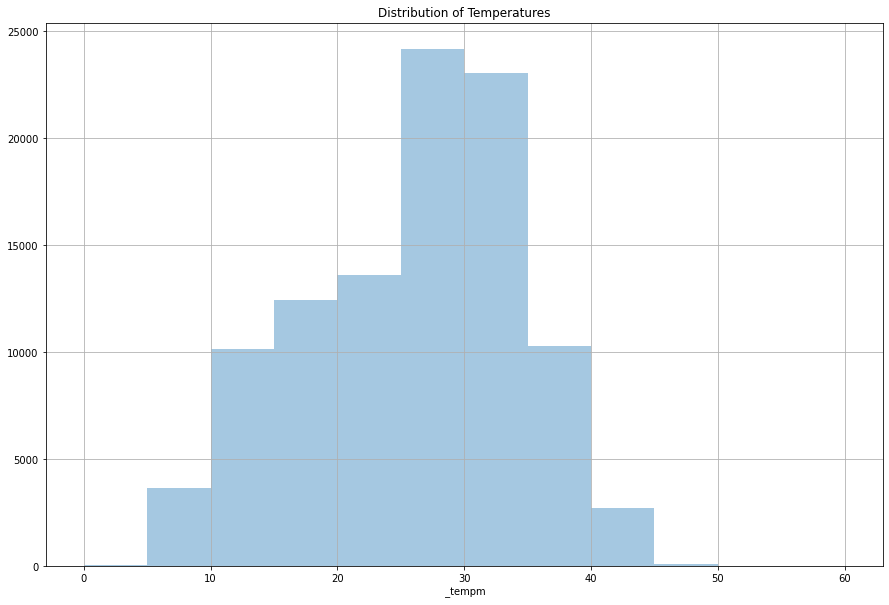

In [7]:
plt.figure(figsize=(15, 10))
sns.distplot(df[' _tempm'],bins=[i for i in range(0,61,5)], kde=False)
plt.title("Distribution of Temperatures")
plt.grid()
plt.show()

In [8]:
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])

In [9]:
df['datetime_utc']

0        1996-11-01 11:00:00
1        1996-11-01 12:00:00
2        1996-11-01 13:00:00
3        1996-11-01 14:00:00
4        1996-11-01 16:00:00
                 ...        
100985   2017-04-24 06:00:00
100986   2017-04-24 09:00:00
100987   2017-04-24 12:00:00
100988   2017-04-24 15:00:00
100989   2017-04-24 18:00:00
Name: datetime_utc, Length: 100990, dtype: datetime64[ns]

In [10]:
# imputing the missing value in temperatre feature with mean.
df[' _tempm'].fillna(df[' _tempm'].mean(), inplace=True)

In [11]:
df[' _tempm'].isna().sum()
# filled all missing values with mean()

0

In [12]:
str(df['datetime_utc'][0])

'1996-11-01 11:00:00'

In [13]:
# a function to extract year part from the whole date
def get_year(x):
  return x[0:4]

In [14]:
# a function to extract month part from the whole date
def get_month(x):
  return x[5:7]

In [15]:
# making two new features year and month
df['year'] = df['datetime_utc'].apply(lambda x: get_year(str(x)))
df['month'] = df['datetime_utc'].apply(lambda x: get_month(str(x)))

In [16]:
df['year']

0         1996
1         1996
2         1996
3         1996
4         1996
          ... 
100985    2017
100986    2017
100987    2017
100988    2017
100989    2017
Name: year, Length: 100990, dtype: object

In [17]:
temp_year = pd.crosstab(df['year'], df['month'], values=df[' _tempm'], aggfunc='mean')

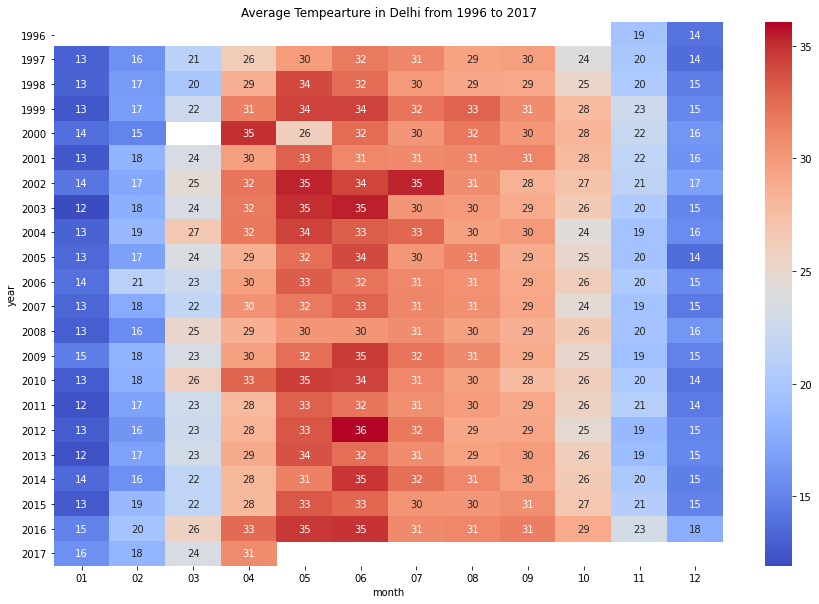

In [18]:
plt.figure(figsize=(15, 10))
sns.heatmap(temp_year, cmap='coolwarm', annot=True)
plt.title("Average Tempearture in Delhi from 1996 to 2017")
plt.show()

In [19]:
df[' _hum'].isna().sum()

757

In [20]:
# imputing missing values in _hum feature with mean
df[' _hum'].fillna(df[' _hum'].mean(), inplace=True)

In [21]:
humidity_year = pd.crosstab(df['year'], df['month'], values=df[' _hum'], aggfunc='mean')

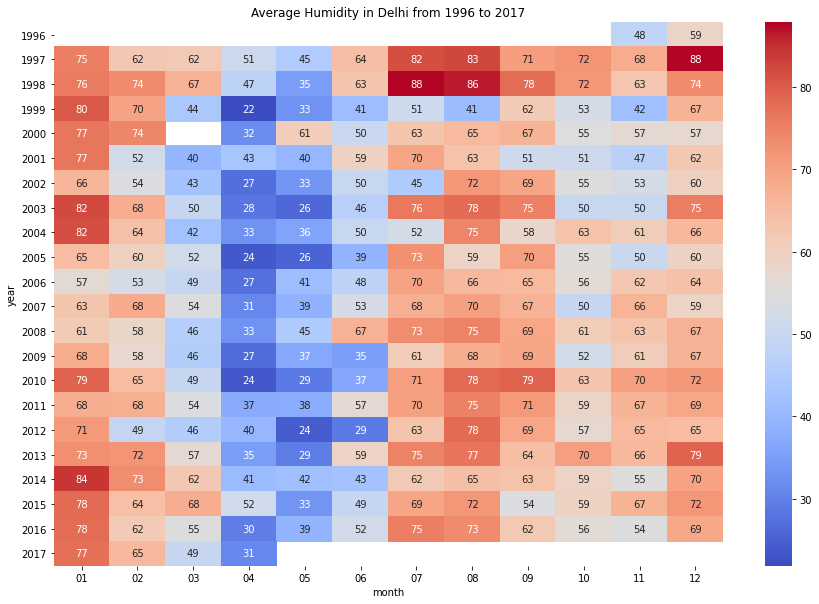

In [22]:
plt.figure(figsize=(15, 10))
sns.heatmap(humidity_year, cmap='coolwarm', annot=True)
plt.title("Average Humidity in Delhi from 1996 to 2017")
plt.show()

In [23]:
# taking only temperature feature as values and datetime feature as index in the dataframe for time series forecasting of temperature
data = pd.DataFrame(list(df[' _tempm']), index=df['datetime_utc'], columns=['temp'])

In [24]:
data

,temp
datetime_utc,
1996-11-01 11:00:00,30.0
1996-11-01 12:00:00,28.0
1996-11-01 13:00:00,24.0
1996-11-01 14:00:00,24.0
1996-11-01 16:00:00,23.0
...,...
2017-04-24 06:00:00,34.0
2017-04-24 09:00:00,38.0
2017-04-24 12:00:00,36.0


In [25]:
# resampling data with date frequency for time series forecasting
data = data.resample('D').mean()

In [26]:
data.temp.isna().sum()

141

In [27]:
data.fillna(data['temp'].mean(), inplace=True)

In [28]:
data.temp.isna().sum()

0

In [29]:
data.shape

(7480, 1)

In [30]:
data

,temp
datetime_utc,
1996-11-01,22.333333
1996-11-02,22.916667
1996-11-03,21.791667
1996-11-04,22.722222
1996-11-05,27.800000
...,...
2017-04-20,34.500000
2017-04-21,34.250000
2017-04-22,32.900000


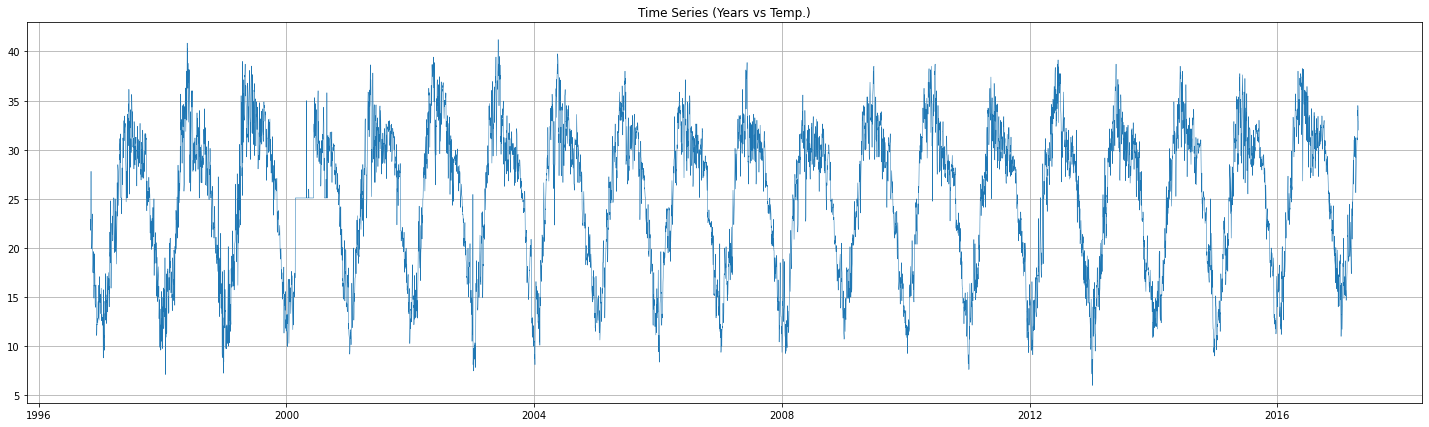

In [31]:
plt.figure(figsize=(25, 7))
plt.plot(data, linewidth=.5)
plt.grid()
plt.title("Time Series (Years vs Temp.)")
plt.show()

In [32]:
# Scaling data to get rid of outliers
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(-1,1))
data_scaled = scalar.fit_transform(data)

In [33]:
data_scaled

array([[-0.07224714],
       [-0.0391131 ],
       [-0.10301445],
       ...,
       [ 0.52795217],
       [ 0.52653214],
       [ 0.47683109]])

In [34]:
data_scaled.shape

(7480, 1)

In [35]:
steps = 30
inp = []
out = []
for i in range(len(data_scaled)- (steps)):
    inp.append(data_scaled[i:i+steps])
    out.append(data_scaled[i+steps])

In [36]:
inp=np.asanyarray(inp)
out=np.asanyarray(out)

In [37]:
x_train = inp[:7300,:,:]
x_test = inp[7300:,:,:]    
y_train = out[:7300]    
y_test= out[7300:]

In [38]:
inp.shape

(7450, 30, 1)

In [39]:
x_train.shape

(7300, 30, 1)

In [40]:
x_test.shape

(150, 30, 1)

In [41]:
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
early_stop = EarlyStopping(monitor = "loss", mode = "min", patience = 7)
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(30,1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(30))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

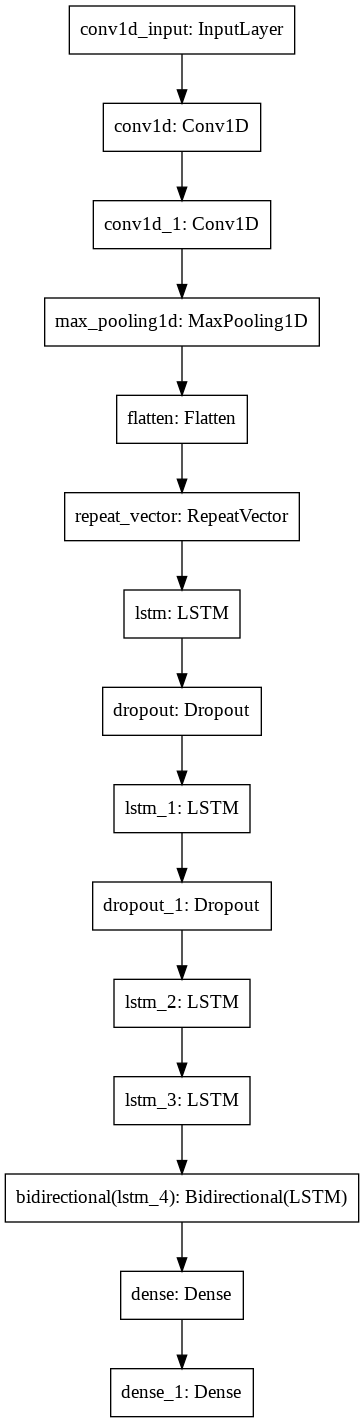

In [42]:
plot_model(model, to_file='model.png')

In [ ]:
history = model.fit(x_train,y_train,epochs=300, verbose=1, callbacks = [early_stop] )

Epoch 1/300
229/229 [==============================] - 71s 260ms/step - loss: 0.1253
Epoch 2/300
 38/229 [===>..........................] - ETA: 48s - loss: 0.0131

In [ ]:
model.save("./regressor.hdf5")

In [ ]:
predict = model.predict(x_test)

In [ ]:
predict = scalar.inverse_transform(predict)

In [ ]:
Ytesting = scalar.inverse_transform(y_test)

In [ ]:
plt.figure(figsize=(20,9))
plt.plot(Ytesting , 'blue', linewidth=5)
plt.plot(predict,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Ytesting, predict)